### Requirements

#### Python packages
- [cython](https://pypi.org/project/Cython/)
- [MDAnalysis](https://pypi.org/project/MDAnalysis/)
- [periodictable](https://pypi.org/project/periodictable/)
- [matplotlib](https://pypi.org/project/matplotlib/)


In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()
import numpy as np
import MDAnalysis as mda
import periodictable
import nsc

/sw/conda/anaconda3/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


### Download water simulation
`wget` and `tar` commands are necessary.  
You may skip this step if running the notebook more than once

In [2]:
%%capture
%%bash
wget https://www.dropbox.com/s/au6k0m84kggq057/water.tar
tar xf water.tar

### Create system and extract coordinates

In [3]:
%%capture
u = mda.Universe("water/npt.gro", "water/nvt.trr")

`u` is a `MDAnalysis.Universe` object. It contains 512 TIP4P water molecules. Each TIP4P water molecule is composed of one oxygen, two hydrogens, and two lone-pair electrons.

In [4]:
print('number of residues =', len(u.residues))
print('Atoms in the first water molecule', u.atoms[0:4])

number of residues = 512
Atoms in the first water molecule <AtomGroup [<Atom 1: OW of type O of resname SOL, resid 1 and segid SYSTEM>, <Atom 2: HW1 of type H of resname SOL, resid 1 and segid SYSTEM>, <Atom 3: HW2 of type H of resname SOL, resid 1 and segid SYSTEM>, <Atom 4: LP1 of type L of resname SOL, resid 1 and segid SYSTEM>]>


Select only the hydrogens and oxygens. There should be three atoms per water molecule

In [5]:
sel = u.select_atoms('type H or type O')
print('number of atoms per water molecule = ', len(sel)/len(u.residues))

number of atoms per water molecule =  3.0


Obtain the bound coherent neutron scattering lengths for our selection.

In [6]:
# the detailed code. See the end of this cell for the one-liner version.
b_c = list()
for atom in sel:
    element_name = atom.type
    element = getattr(periodictable, element_name)
    b_c.append(element.neutron.b_c)
b_c = np.asarray(b_c)
# The one-liner version
#b_c = np.asarray([getattr(periodictable, at.type).neutron.b_c  for at in sel])

In [7]:
print(b_c)  # units in fm

[ 5.805  -3.7409 -3.7409 ...  5.805  -3.7409 -3.7409]


We investigate the trajectory.

In [8]:
print('number of conformations =', u.trajectory.n_frames)
print('Size of the box, in Angstroms =', u.dimensions[0:3])
print('It is a cubic box, as evidenced by the angles between box sides: ',u.dimensions[3:])

number of conformations = 5001
Size of the box, in Angstroms = [24.893501 24.893501 24.893501]
It is a cubic box, as evidenced by the angles between box sides:  [90. 90. 90.]


We will calculate the structure factor for 1000 conformations, out of the 5001. We extract one conformation every 5. We only care about our hydrogen + oxygen selection `sel`.

In [9]:
tr = np.asarray([sel.positions for _ in u.trajectory[0:-1:5]])  # from beginning (0) to end (-1) every 5
print(tr.shape)  #  1000 conformations, 1536 atoms per conformation, 3 coordinates (x, y, z) per atoms

(1000, 1536, 3)


### Calculate the coherent static structure factor `S(q)`

We first generate a set of momentum transfer vectors with 100 random orientations and with modulus between 0.1 and 1, with 20 different moduli. Units are inverse Angstroms because the length units of of the trajectory are Angstroms.

After generation of the momentum transfer vector set, we can calculate `S(q)`. We need also the scattering lengths and the coordinates of interest.


In [40]:
q = nsc.qvec.sphere_average(q_mod_min=0, q_mod_max=2.0, n_q_mod=100, nvec=100)
q_mod = nsc.qvec.moduli(q_mod_min=0, q_mod_max=2.0, n_q_mod=100)  # list of q moduli

In [38]:
print(b_c.shape)
b_ones = np.ones(len(b_c))
print(b_ones)

(1536,)
[1. 1. 1. ... 1. 1. 1.]


In [39]:
#s = nsc.elastic.structure_factor.structure_factor(q, tr, b_c)
s = nsc.elastic.structure_factor.structure_factor(q, tr, b_ones)

100%|██████████| 100/100 [18:12<00:00, 10.93s/it]


<IPython.core.display.Javascript object>


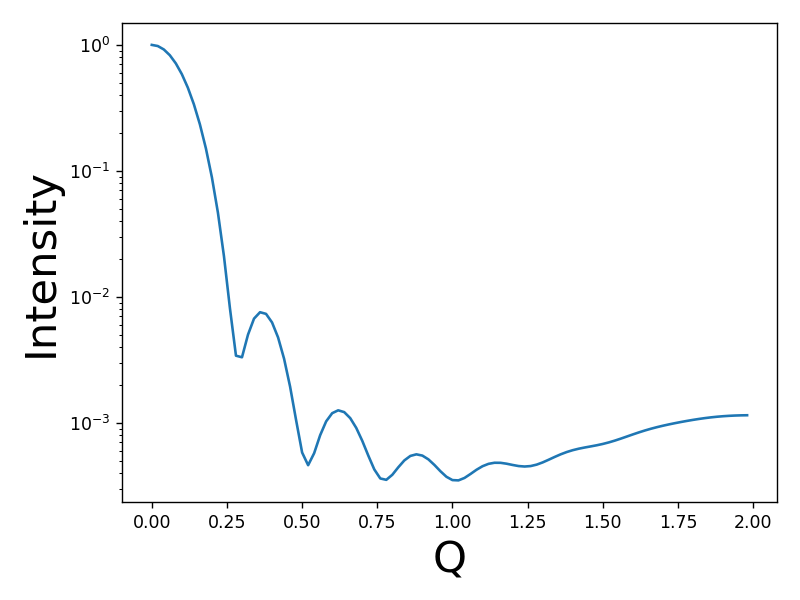

In [41]:
fig, ax = plt.subplots(1,1)
ax.plot(q_mod, s)
ax.set_xlabel('Q', size=25)
ax.set_ylabel('Intensity', size=25)
ax.set_yscale('log')
#ax.set_xscale('log')
plt.tight_layout()
plt.show()